# Chapter 07 시계열 데이터를 다뤄보자

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/MyDrive/data/data_science')
# sys.path.append(os.chdir)

## 7.1 Numpy의 polyfit으로 regression 분석하기

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas_datareader.data as web

from fbprophet import Prophet
from datetime import datetime

웹사이트 트레픽 정보 가져오기

In [5]:
pinkwink_web = pd.read_csv('./08. PinkWink Web Traffic.csv',
                           encoding='utf-8', thousands=',',
                           names = ['date', 'hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


In [6]:
pinkwink_web.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 16. 7. 1. to 17. 6. 30.
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hit     365 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB


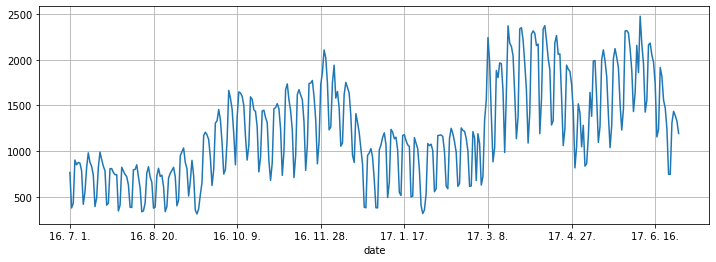

In [7]:
pinkwink_web['hit'].plot(figsize=(12, 4), grid=True)

육안으로 봤을때는 추세나 주기성이 있는거 같음.

차분할 필요가 있어보임.

정확한 주기성 확인을 위해 모델 형성 후 적합

In [8]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

In [9]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2))

In [10]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

func = [f1, f2, f3, f15]

for f in func:
    print(error(f, time, traffic))

430.8597308110963
430.6284101894695
429.53280466762925
330.47773021321143


1,2,3차는 에러가 비슷함.

15차가 에러가 가장 작지만 과적합된걸로 보임.

그래프로 결과확인.

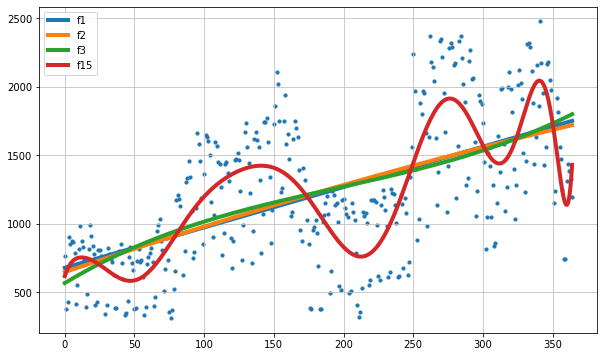

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')
plt.legend(loc=2)
plt.show()

## 7.2 Prophet 모듈을 이용한 forecast 예측

In [12]:
# 날짜와 방문수 따로 저장
df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format="%y. %m. %d.")
del df['date']

m = Prophet(yearly_seasonality=True)
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,923.291666,721.899840,1132.338700
421,2017-08-26,508.365029,295.660336,720.609058
422,2017-08-27,640.847489,420.531311,843.375646
423,2017-08-28,1193.387766,978.211423,1400.905435
424,2017-08-29,1229.217425,1023.124907,1435.135610


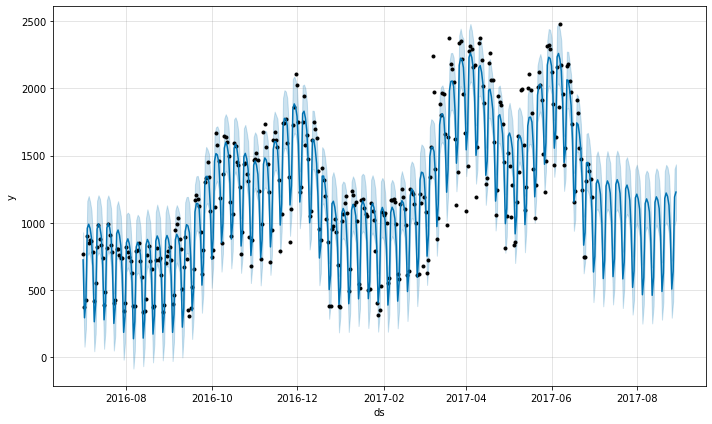

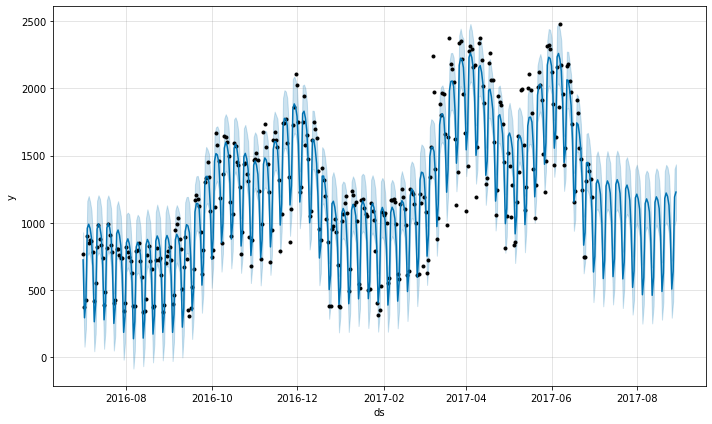

In [15]:
# 예측값 그래프
m.plot(forecast)

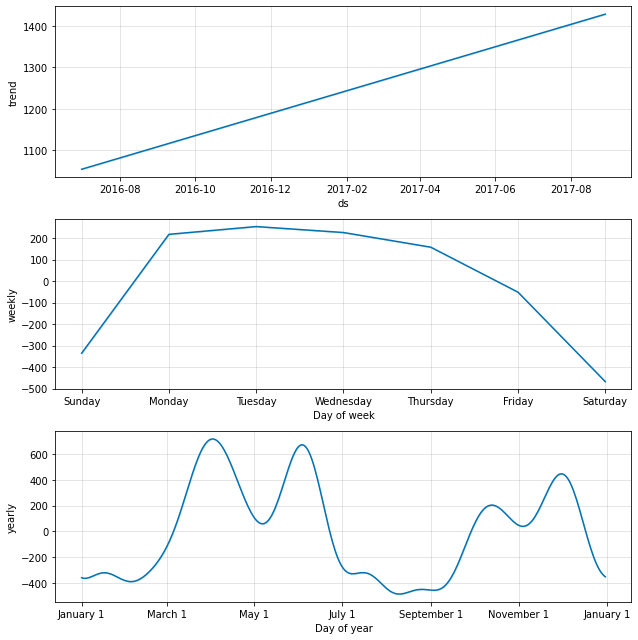

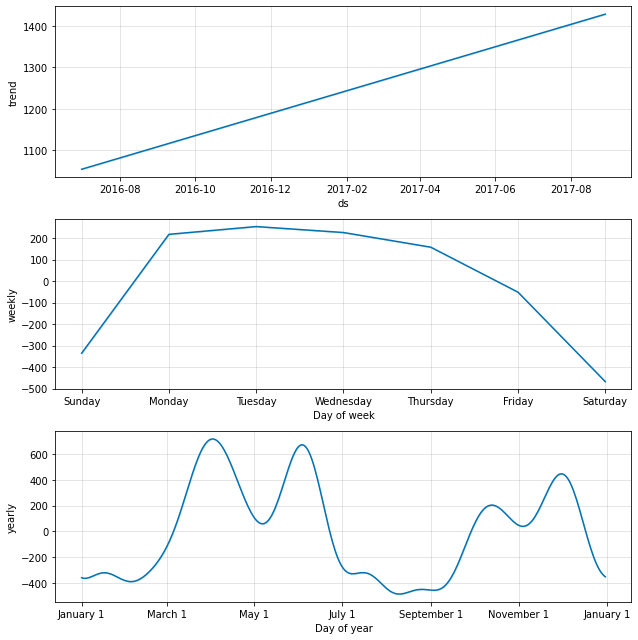

In [16]:
m.plot_components(forecast)

## 7.3 Seasonal 시계열 분석으로 주식 데이터 분석하기

pandas의 DataReader 함수를 통해 주가 정보 받아올 수 있음,

In [17]:
!pip install yfinance

In [18]:
import yfinance as yf

In [21]:
start = datetime(2003, 1, 2)
end   = datetime(2022, 3, 4)

yf.pdr_override()

KIA = web.get_data_yahoo('000270.KS', start, end)
KIA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-02,9000.0,9200.0,8950.0,9190.0,6607.209473,688900
2003-01-03,9350.0,9720.0,9330.0,9550.0,6866.034180,1419800
2003-01-06,9720.0,9760.0,9500.0,9700.0,6973.877441,1076300
2003-01-07,9900.0,9920.0,9420.0,9420.0,6772.570801,1034100
2003-01-08,9500.0,9740.0,9400.0,9520.0,6844.465332,599800


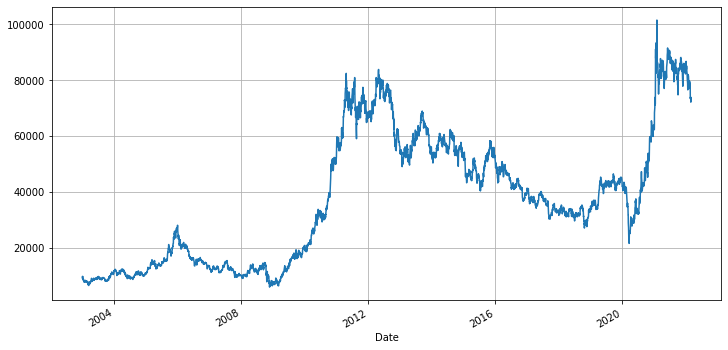

In [22]:
# 종가 기준 그래프
KIA['Close'].plot(figsize=(12,6), grid=True)

In [33]:
# 일부데이터를 잘라서 forecast
KIA_trunc = KIA[:'2021-02-01']
KIA_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-02,9000.0,9200.0,8950.0,9190.0,6607.209473,688900
2003-01-03,9350.0,9720.0,9330.0,9550.0,6866.034180,1419800
2003-01-06,9720.0,9760.0,9500.0,9700.0,6973.877441,1076300
2003-01-07,9900.0,9920.0,9420.0,9420.0,6772.570801,1034100
2003-01-08,9500.0,9740.0,9400.0,9520.0,6844.465332,599800
...,...,...,...,...,...,...
2021-01-26,91700.0,92200.0,88700.0,89700.0,86515.382812,5807061
2021-01-27,89500.0,94600.0,88100.0,90000.0,86804.734375,10756099
2021-01-28,87400.0,91900.0,87400.0,88200.0,85068.640625,6993254


In [34]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']
df.head()

,ds,y
0,2003-01-02,9190.0
1,2003-01-03,9550.0
2,2003-01-06,9700.0
3,2003-01-07,9420.0
4,2003-01-08,9520.0


In [35]:
# 1년 후 까지의 예측
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4879,2022-01-28
4880,2022-01-29
4881,2022-01-30
4882,2022-01-31
4883,2022-02-01


In [37]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4879,2022-01-28,50024.214144,42168.316929,58252.920957
4880,2022-01-29,50723.758180,42458.426565,59172.942349
4881,2022-01-30,50567.024777,42521.192960,58538.976530
4882,2022-01-31,49639.824956,41178.515171,57675.748975
4883,2022-02-01,49523.224377,41474.642576,58049.313902


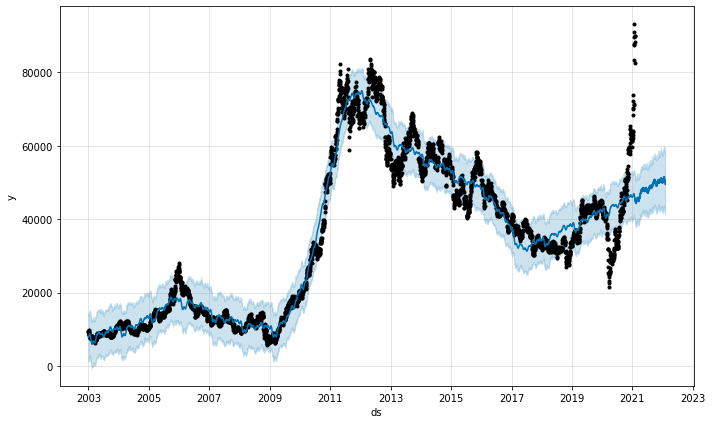

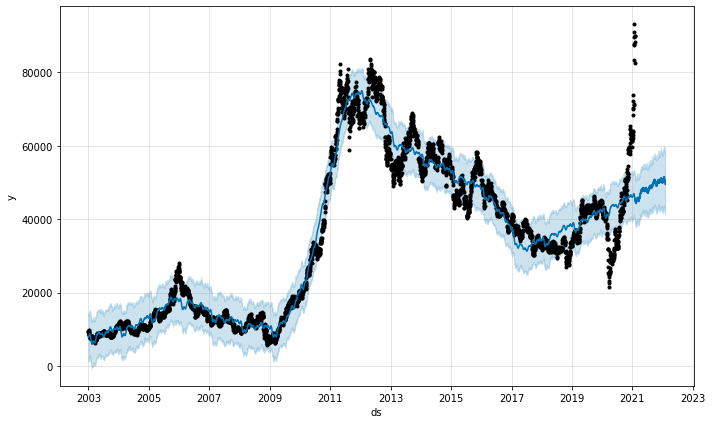

In [38]:
m.plot(forecast)

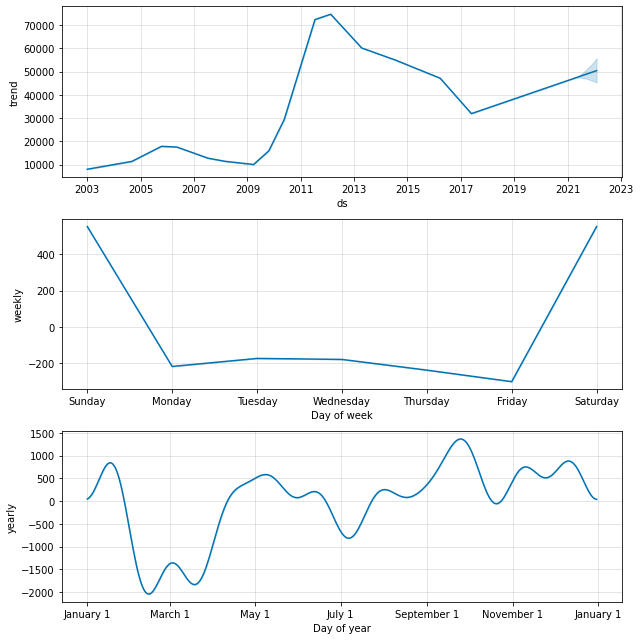

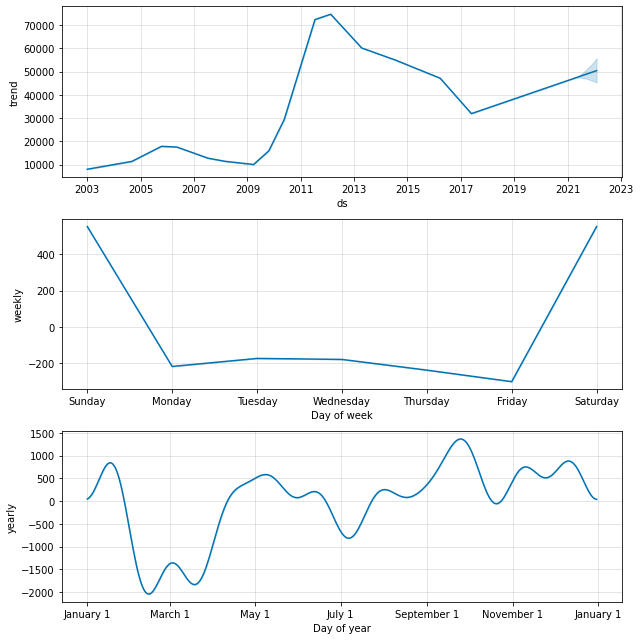

In [39]:
m.plot_components(forecast)

주간 데이터 상으론 화,수의 주가가 높고, 1년 중에는 2,3월경이 상대적으로 낮은 주가를 보임.

[*********************100%***********************]  1 of 1 completed


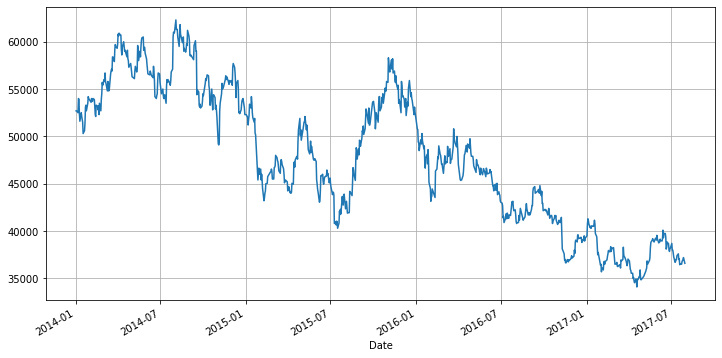

In [40]:
# 기간 변경
start = datetime(2014, 1, 1)
end = datetime(2017, 7, 31)

KIA = web.get_data_yahoo('000270.KS', start, end)
KIA['Close'].plot(figsize=(12, 6), grid=True)

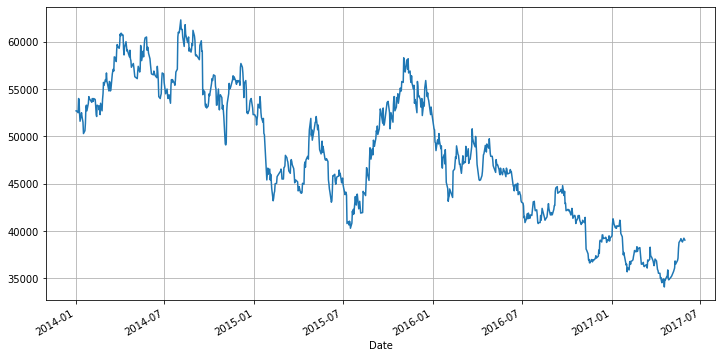

In [41]:
# 2017-5-31까지의 데이터를 예측용으로 사용
KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize=(12, 6), grid=True)

In [44]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']

In [45]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
future = m.make_future_dataframe(periods=61)
future.tail()

,ds
897,2017-07-27
898,2017-07-28
899,2017-07-29
900,2017-07-30
901,2017-07-31


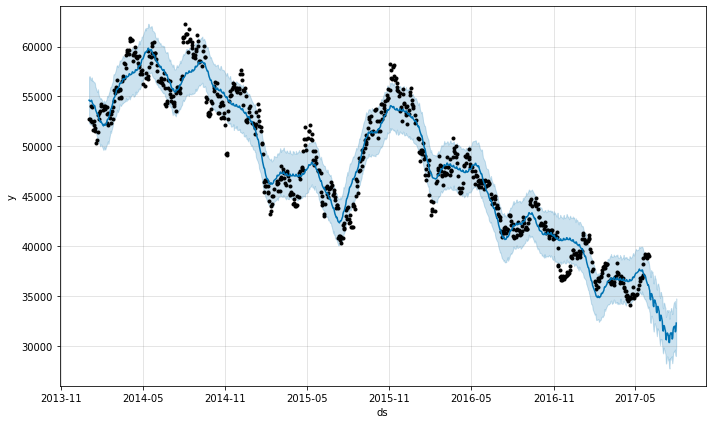

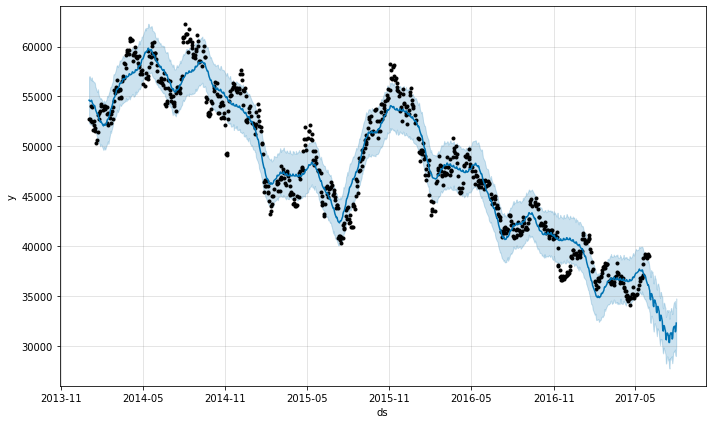

In [47]:
forecast = m.predict(future)
m.plot(forecast)

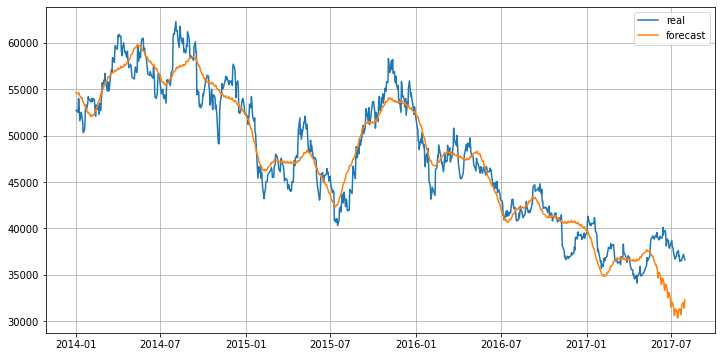

In [48]:
# 실제 값과 비교
plt.figure(figsize=(12, 6))
plt.plot(KIA.index, KIA['Close'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

## 7.4 Growth Model과 Holiday Forecast

In [49]:
# 간단한 예제
df = pd.read_csv('./08. example_wp_R.csv')
df['y'] = np.log(df['y'])

In [50]:
df['cap'] = 8.5

In [53]:
m = Prophet(growth='logistic')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


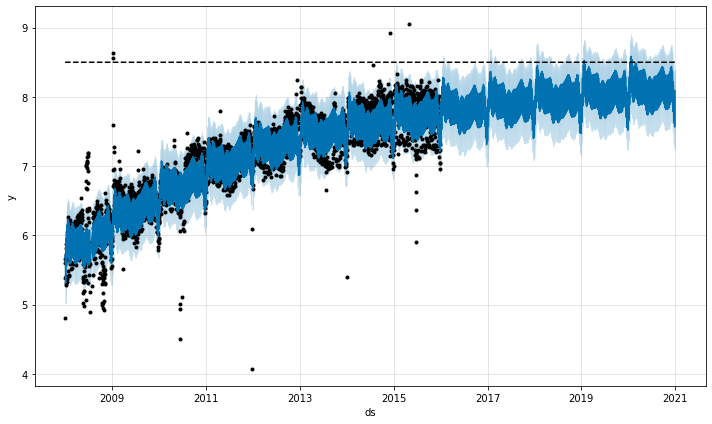

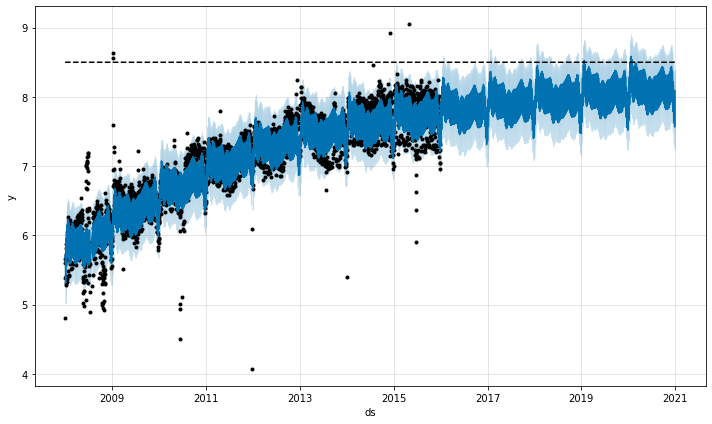

In [54]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
m.plot(fcst)

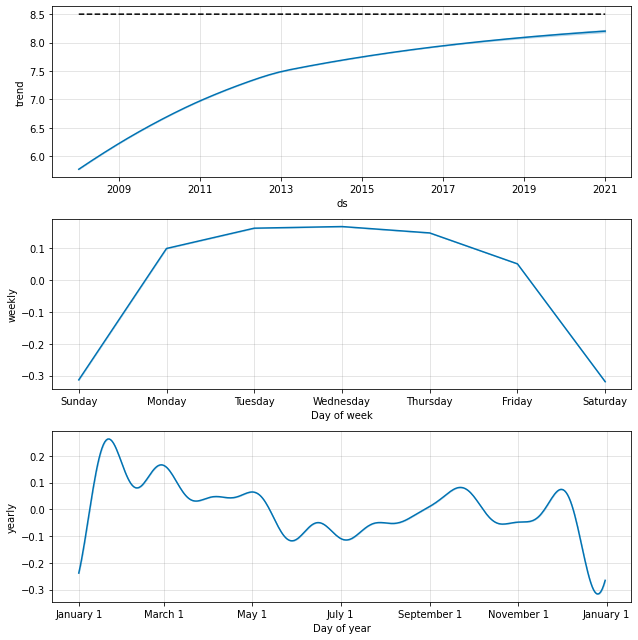

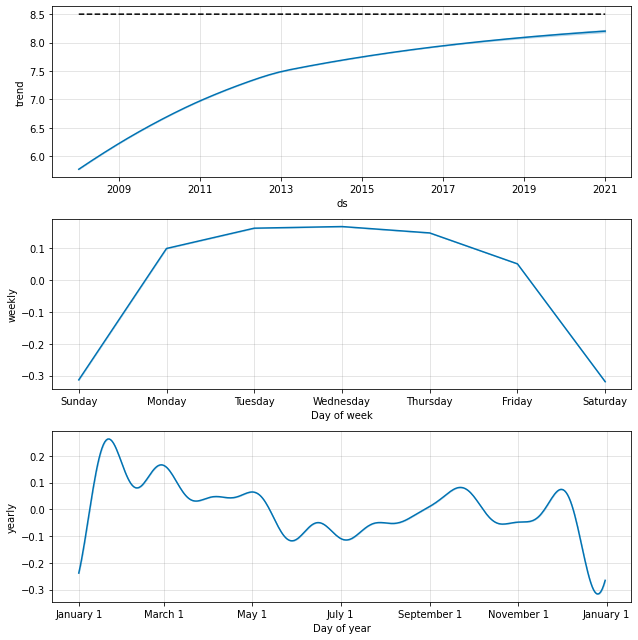

In [55]:
forecast = m.predict(future)
m.plot_components(forecast)